In [29]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
import seaborn as sns

In [2]:
coagulation = pd.read_excel("coagulation_parsed.xlsx")

In [4]:
tma = pd.read_excel("ready characteritstics (1).xlsx")
tma = tma[tma["tma_date"].notna()][tma["id"].isin(ids_new)
tma['date_hsct'] = pd.to_datetime(tma['date_hsct'])
tma['tma_date'] = pd.to_datetime(tma['tma_date'])
tma["date_diff"] = tma["tma_date"] - tma["date_hsct"]
tma_id = tma["id"].tolist()

C:\Users\admin\AppData\Local\Temp\ipykernel_28320\4147496155.py:4: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  tma['tma_date'] = pd.to_datetime(tma['tma_date'])


In [5]:
suspect = pd.read_excel("suspected_tma_with_date_opp.xlsx")
iids = set(suspect["patient_id"].tolist() + tma_id)

In [20]:
coag = coagulation[coagulation["Test"].isin(["INR", "APTT"])]
coag = coag[coag["Рег.№"].isin(iids)]
tma_date = tma[["id", "tma_date"]]
suspect_date = suspect[["patient_id", "date_opp_after"]]
suspect_date = suspect_date.rename(columns={"patient_id": "id", "date_opp_after": "tma_date"})
id90 = pd.concat([tma_date, suspect_date]).drop_duplicates(subset="id")
coag = pd.merge(coag, id90, left_on='Рег.№', right_on='id', how="left")

In [21]:
inr = []
aptt = []

blood_complication = []
for p in iids: 
    df_p = coag[coag['Рег.№'] == p]
    df_p_date = df_p[(df_p['Дата забора'] + timedelta(days=5) >= df_p['tma_date']) & (df_p['Дата забора'] - timedelta(days=5) <= df_p['tma_date'])]

    
    if len(df_p_date) > 0:
        if max(df_p_date[df_p_date["Test"] == "INR"]["Value"].astype(float)) > 2:
            id_max = df_p_date[df_p_date["Test"] == "INR"]["Value"].astype(float).idxmax()
            inr.append([p, df_p_date.loc[id_max, 'Дата забора'], "INR", df_p_date.loc[id_max, 'Value']])

        if max(df_p_date[df_p_date["Test"] == "APTT"]["Value"].astype(float)) > 40:
            id_max = df_p_date[df_p_date["Test"] == "APTT"]["Value"].astype(float).idxmax()
            aptt.append([p, df_p_date.loc[id_max, 'Дата забора'], "APTT", df_p_date.loc[id_max, 'Value']])
        # idx_max_bef = df_p_bef['Результаты'].idxmax()
        # date_max_bef = df_p_bef.loc[idx_max_bef, 'Дата забора']
        # idx_max_aft = df_p_aft['Результаты'].idxmax()
        # date_max_aft = df_p_aft.loc[idx_max_aft, 'Дата забора']
        # opp.append([p, max(df_p_bef['Результаты']), date_max_bef, max(df_p_aft['Результаты']), date_max_aft, df_p_aft.loc[idx_max_aft, 'date_hsct']])
# print(len(inr), len(aptt))

In [22]:
ids_blood = []
for i in inr:
    ids_blood.append(i[0])

for i in aptt:
    ids_blood.append(i[0])

print(len(inr), len(aptt), len(set(ids_blood)))

# pd.DataFrame(inr, columns=['id', 'Дата забора', 'Test', 'Value']).to_excel("INR.xlsx")
# pd.DataFrame(aptt, columns=['id', 'Дата забора', 'Test', 'Value']).to_excel("APTT.xlsx")

25 68 69


In [23]:
# Sample data (replace with your actual dataframe)
# df = pd.DataFrame({
#     'time': [-9, -7, -5, -3, 1, 6, 7, 10, 11],
#     'value': np.random.randn(9)  # Random values for example
# })

def create_custom_intervals(time_series):
    """Create 5-day intervals centered around zero"""
    intervals = []
    current_start = 0
    
    # Handle positive times
    max_time = np.ceil(time_series.max())
    while current_start <= max_time:
        intervals.append((current_start, current_start + 10))
        current_start += 10
    
    # Handle negative times
    current_start = 0
    min_time = np.floor(time_series.min())
    while current_start >= min_time:
        intervals.append((current_start - 10, current_start))
        current_start -= 10
    
    # Sort intervals
    intervals = sorted(intervals, key=lambda x: x[0])
    return intervals

In [24]:
interesting_intervals = ["(-60, -50]", "(-50, -40]", "(-40, -30]", "(-30, -20]", "(-20, -10]", "(-10, 0]", "(0, 10]", "(10, 20]", "(20, 30]", "(30, 40]", "(40, 50]", "(50, 60]"]

In [25]:
def spl(date):
    return int(date.split(" days ")[0])

In [27]:
inr = coag[coag["Test"] == "INR"]
inr["delta_time"] = inr["Дата забора"] - inr["tma_date"]
    
inr["delta_time"] = inr["delta_time"].astype(str).apply(spl)

# Create custom intervals based on your time data
intervals = create_custom_intervals(inr['delta_time'])
# intervals
# # Create labels for the intervals
labels = [f"({int(start)}, {int(end)}]" for start, end in intervals]

# # Assign each time point to its interval
inr['time_interval'] = pd.cut(
    inr['delta_time'],
    bins=[-np.inf] + [end for start, end in intervals[:-1]] + [np.inf],
    labels=labels
)

inr = inr[inr["time_interval"].isin(interesting_intervals)]


aptt = coag[coag["Test"] == "APTT"]
aptt["delta_time"] = aptt["Дата забора"] - aptt["tma_date"]

    
aptt["delta_time"] = aptt["delta_time"].astype(str).apply(spl)

# Create custom intervals based on your time data
intervals = create_custom_intervals(aptt['delta_time'])
# intervals
# # Create labels for the intervals
labels = [f"({int(start)}, {int(end)}]" for start, end in intervals]

# # Assign each time point to its interval
aptt['time_interval'] = pd.cut(
    aptt['delta_time'],
    bins=[-np.inf] + [end for start, end in intervals[:-1]] + [np.inf],
    labels=labels
)

aptt = aptt[aptt["time_interval"].isin(interesting_intervals)]

C:\Users\admin\AppData\Local\Temp\ipykernel_28320\3164343109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inr["delta_time"] = inr["Дата забора"] - inr["tma_date"]
C:\Users\admin\AppData\Local\Temp\ipykernel_28320\3164343109.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inr["delta_time"] = inr["delta_time"].astype(str).apply(spl)
C:\Users\admin\AppData\Local\Temp\ipykernel_28320\3164343109.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

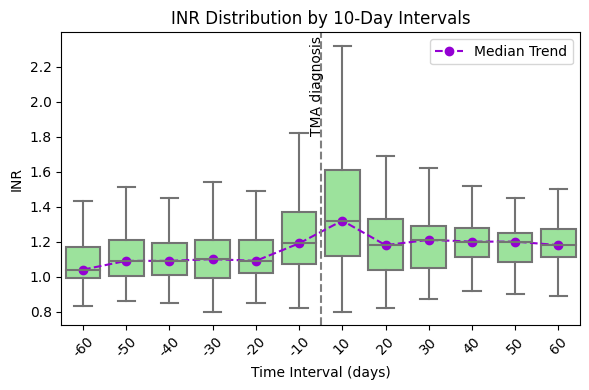

In [30]:
# Create the boxplot
inr["Value"] = inr["Value"].astype(float)

plt.figure(figsize=(6, 4))
sns.boxplot(
    x='time_interval', 
    y='Value', 
    data=inr,
    showfliers=False,  # Hide outliers for cleaner plot
    color='lightgreen'
)

# Add trend line (median for each interval)
medians = inr.groupby('time_interval')['Value'].median()
plt.plot(medians.index, medians.values, color='darkviolet', marker='o', linestyle='--', label='Median Trend')

# # Format the plot
plt.title('INR Distribution by 10-Day Intervals')
plt.xlabel('Time Interval (days)')
plt.ylabel('INR')
plt.xticks(ticks = interesting_intervals, labels= [i for i in range(-60, 70, 10) if i != 0], rotation=45)

plt.axvline(x=len([i for i in intervals if i[0] < 0])-0.5, color='gray', linestyle='--')
plt.text(len([i for i in intervals if i[0] < 0])-0.75, plt.ylim()[1]-0.02, 'TMA diagnosis', rotation=90, va='top')
plt.legend()
plt.tight_layout()

plt.savefig("inr.png")
plt.show()



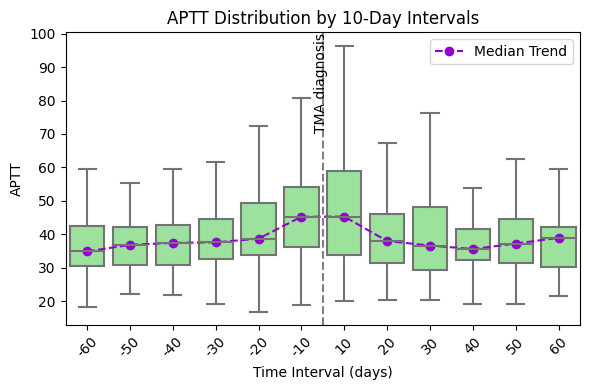

In [31]:
# Create the boxplot
aptt["Value"] = aptt["Value"].astype(float)

plt.figure(figsize=(6, 4))
sns.boxplot(
    x='time_interval', 
    y='Value', 
    data=aptt,
    showfliers=False,  # Hide outliers for cleaner plot
    color='lightgreen'
)

# Add trend line (median for each interval)
medians = aptt.groupby('time_interval')['Value'].median()
plt.plot(medians.index, medians.values, color='darkviolet', marker='o', linestyle='--', label='Median Trend')

# # Format the plot
plt.title('APTT Distribution by 10-Day Intervals')
plt.xlabel('Time Interval (days)')
plt.ylabel('APTT')
plt.xticks(ticks = interesting_intervals, labels= [i for i in range(-60, 70, 10) if i != 0], rotation=45)

plt.axvline(x=len([i for i in intervals if i[0] < 0])-0.5, color='gray', linestyle='--')
plt.text(len([i for i in intervals if i[0] < 0])-0.7, plt.ylim()[1]-0.05, 'TMA diagnosis', rotation=90, va='top')
plt.legend()
plt.tight_layout()
plt.savefig("aptt.png")
plt.show()

In [33]:
test_results = pd.read_excel("sch_alt_ast_bil_crea_urea_parsed.xlsx")
test_results = test_results[test_results["Рег.№"].isin(iids)]
test_results = pd.merge(test_results, id90, left_on='Рег.№', right_on='id', how="left")

In [34]:

test_results["delta_time"] = test_results["Дата забора"] - test_results["tma_date"]

def spl(date):
    return int(date.split(" days ")[0])
    
test_results["delta_time"] = test_results["delta_time"].astype(str).apply(spl)

# Create custom intervals based on your time data
intervals = create_custom_intervals(test_results['delta_time'])
# intervals
# # Create labels for the intervals
labels = [f"({int(start)}, {int(end)}]" for start, end in intervals]

# # Assign each time point to its interval
test_results['time_interval'] = pd.cut(
    test_results['delta_time'],
    bins=[-np.inf] + [end for start, end in intervals[:-1]] + [np.inf],
    labels=labels
)

test_results = test_results[test_results["time_interval"].isin(interesting_intervals)]

C:\Users\admin\AppData\Local\Temp\ipykernel_28320\1054828749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crea["Результаты"] = crea["Результаты"].astype(float)


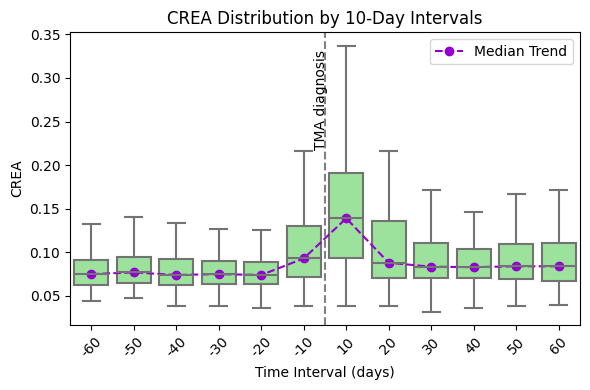

In [35]:
crea = test_results[test_results["Синоним"] == "CREA"]

# Create the boxplot
crea["Результаты"] = crea["Результаты"].astype(float)

plt.figure(figsize=(6, 4))
sns.boxplot(
    x='time_interval', 
    y='Результаты', 
    data=crea,
    showfliers=False,  # Hide outliers for cleaner plot
    color='lightgreen'
)

# Add trend line (median for each interval)
medians = crea.groupby('time_interval')['Результаты'].median()
plt.plot(medians.index, medians.values, color='darkviolet', marker='o', linestyle='--', label='Median Trend')

# # Format the plot
plt.title('CREA Distribution by 10-Day Intervals')
plt.xlabel('Time Interval (days)')
plt.ylabel('CREA')
plt.xticks(ticks = interesting_intervals, labels= [i for i in range(-60, 70, 10) if i != 0], rotation=45)

plt.axvline(x=len([i for i in intervals if i[0] < 0])-0.5, color='gray', linestyle='--')
plt.text(len([i for i in intervals if i[0] < 0])-0.75, plt.ylim()[1]-0.02, 'TMA diagnosis', rotation=90, va='top')
plt.legend()
plt.tight_layout()

plt.savefig("crea.png")
plt.show()



C:\Users\admin\AppData\Local\Temp\ipykernel_28320\3561426223.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldh["Результаты"] = ldh["Результаты"].astype(float)


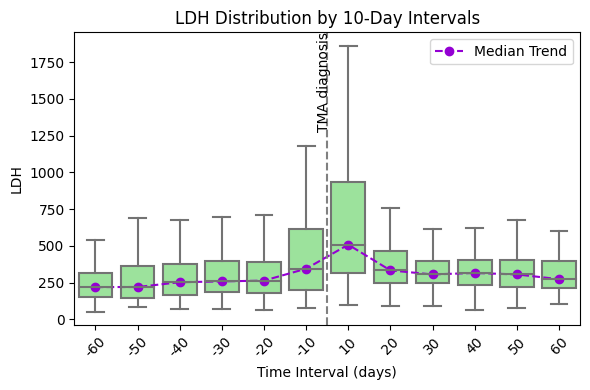

In [36]:
ldh = test_results[test_results["Синоним"] == "LDH"]

# Create the boxplot
ldh["Результаты"] = ldh["Результаты"].astype(float)

plt.figure(figsize=(6, 4))
sns.boxplot(
    x='time_interval', 
    y='Результаты', 
    data=ldh,
    showfliers=False,  # Hide outliers for cleaner plot
    color='lightgreen'
)

# Add trend line (median for each interval)
medians = ldh.groupby('time_interval')['Результаты'].median()
plt.plot(medians.index, medians.values, color='darkviolet', marker='o', linestyle='--', label='Median Trend')

# # Format the plot
plt.title('LDH Distribution by 10-Day Intervals')
plt.xlabel('Time Interval (days)')
plt.ylabel('LDH')
plt.xticks(ticks = interesting_intervals, labels= [i for i in range(-60, 70, 10) if i != 0], rotation=45)

plt.axvline(x=len([i for i in intervals if i[0] < 0])-0.5, color='gray', linestyle='--')
plt.text(len([i for i in intervals if i[0] < 0])-0.75, plt.ylim()[1]-0.02, 'TMA diagnosis', rotation=90, va='top')
plt.legend()
plt.tight_layout()

plt.savefig("ldh.png")
plt.show()



In [37]:
kak = pd.read_excel("kak_parsed.xlsx")
kak = kak[kak["Рег.№"].isin(iids)]
kak = pd.merge(kak, id90, left_on='Рег.№', right_on='id', how="left")
kak["delta_time"] = kak["Дата забора"] - kak["tma_date"]

def spl(date):
    return int(date.split(" days ")[0])
    
kak["delta_time"] = kak["delta_time"].astype(str).apply(spl)

# Create custom intervals based on your time data
intervals = create_custom_intervals(kak['delta_time'])
# intervals
# # Create labels for the intervals
labels = [f"({int(start)}, {int(end)}]" for start, end in intervals]

# # Assign each time point to its interval
kak['time_interval'] = pd.cut(
    kak['delta_time'],
    bins=[-np.inf] + [end for start, end in intervals[:-1]] + [np.inf],
    labels=labels
)

kak = kak[kak["time_interval"].isin(interesting_intervals)]

C:\Users\admin\AppData\Local\Temp\ipykernel_28320\298653085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hgb["Value"] = hgb["Value"].astype(float)


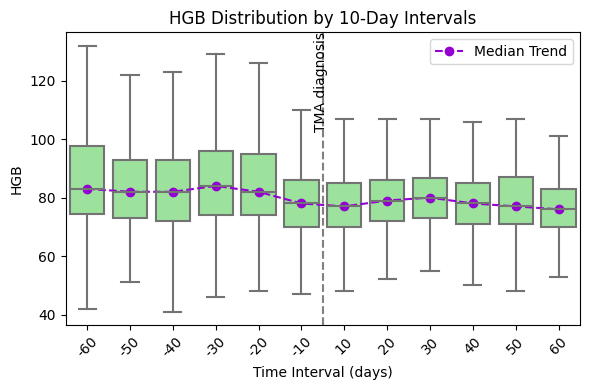

In [38]:
hgb = kak[kak["Test"] == "HGB"] #PLT

# Create the boxplot
hgb["Value"] = hgb["Value"].astype(float)

plt.figure(figsize=(6, 4))
sns.boxplot(
    x='time_interval', 
    y='Value', 
    data=hgb,
    showfliers=False,  # Hide outliers for cleaner plot
    color='lightgreen'
)

# Add trend line (median for each interval)
medians = hgb.groupby('time_interval')['Value'].median()
plt.plot(medians.index, medians.values, color='darkviolet', marker='o', linestyle='--', label='Median Trend')

# # Format the plot
plt.title('HGB Distribution by 10-Day Intervals')
plt.xlabel('Time Interval (days)')
plt.ylabel('HGB')
plt.xticks(ticks = interesting_intervals, labels= [i for i in range(-60, 70, 10) if i != 0], rotation=45)

plt.axvline(x=len([i for i in intervals if i[0] < 0])-0.5, color='gray', linestyle='--')
plt.text(len([i for i in intervals if i[0] < 0])-0.7, plt.ylim()[1]-0.05, 'TMA diagnosis', rotation=90, va='top')
plt.legend()
plt.tight_layout()
plt.savefig("hgb.png")
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_28320\2997683075.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt1["Value"] = plt1["Value"].astype(float)


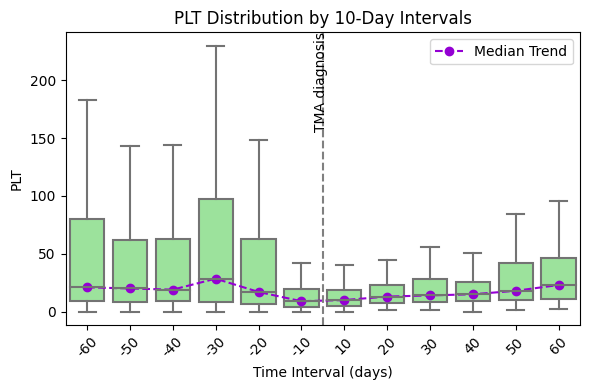

In [39]:
plt1 = kak[kak["Test"] == "PLT"] #PLT

# Create the boxplot
plt1["Value"] = plt1["Value"].astype(float)

plt.figure(figsize=(6, 4))
sns.boxplot(
    x='time_interval', 
    y='Value', 
    data=plt1,
    showfliers=False,  # Hide outliers for cleaner plot
    color='lightgreen'
)

# Add trend line (median for each interval)
medians = plt1.groupby('time_interval')['Value'].median()
plt.plot(medians.index, medians.values, color='darkviolet', marker='o', linestyle='--', label='Median Trend')

# # Format the plot
plt.title('PLT Distribution by 10-Day Intervals')
plt.xlabel('Time Interval (days)')
plt.ylabel('PLT')
plt.xticks(ticks = interesting_intervals, labels= [i for i in range(-60, 70, 10) if i != 0], rotation=45)

plt.axvline(x=len([i for i in intervals if i[0] < 0])-0.5, color='gray', linestyle='--')
plt.text(len([i for i in intervals if i[0] < 0])-0.7, plt.ylim()[1]-0.05, 'TMA diagnosis', rotation=90, va='top')
plt.legend()
plt.tight_layout()
plt.savefig("plt.png")
plt.show()